<a href="https://colab.research.google.com/github/Kimiko00/Training-Anomaly-Detection/blob/main/sensor_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import regularizers
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
sns.set(color_codes=True)
tf.random.set_seed(10)
np.random.seed(10)

In [ ]:
data_dir = '/content/gdrive/MyDrive/Bearing_Sensor_Data'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t', error_bad_lines=False)
    dataset_mean_abs = np.array(dataset.mean().abs())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,-4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

merged_data.index = pd.to_datetime(merged_data.index, format='%Y%m%d%H%M%S', errors='ignore')
merged_data = merged_data.sort_index()
merged_data.to_csv('Average_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

b'Skipping line 4: expected 2 fields, saw 5\n'


Dataset shape: (983, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
.DS_Store,NaN,NaN,NaN,NaN
2004.02.12.10.52.39,0.002490,0.001695,0.001595,0.003487
2004.02.12.11.02.39,0.002278,0.002396,0.003139,0.003739
2004.02.12.11.12.39,0.002401,0.001560,0.001163,0.002705
2004.02.12.11.22.39,0.001616,0.001447,0.000852,0.002821


In [ ]:
train = merged_data['2004.02.12 10:52:39': '2004.02.15 12:52:39']
test = merged_data['2004.02.15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Testing dataset shape:", test.shape)

Training dataset shape: (367, 4)
Testing dataset shape: (615, 4)


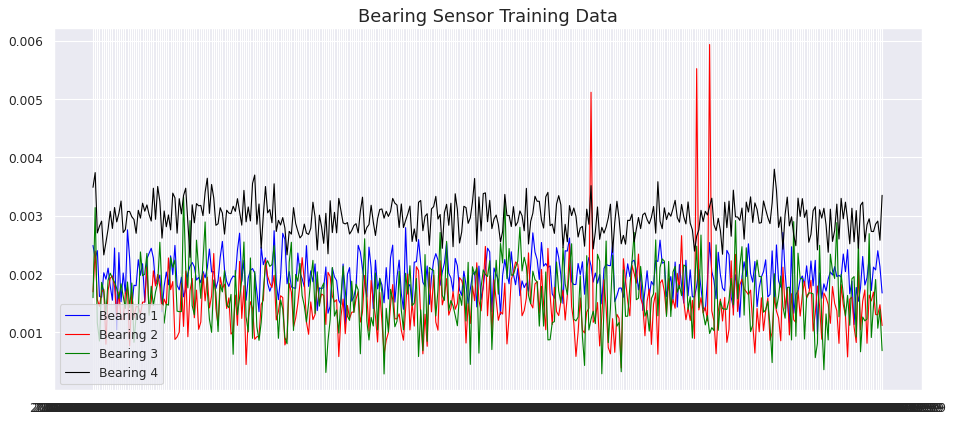

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [ ]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

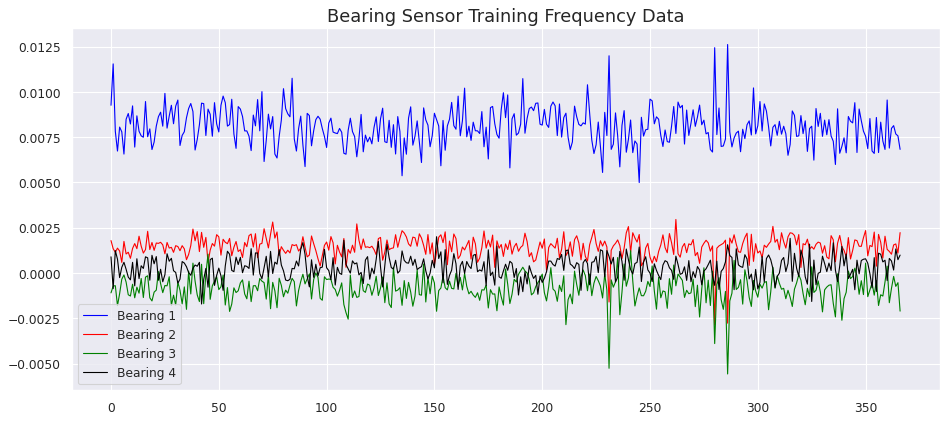

In [ ]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

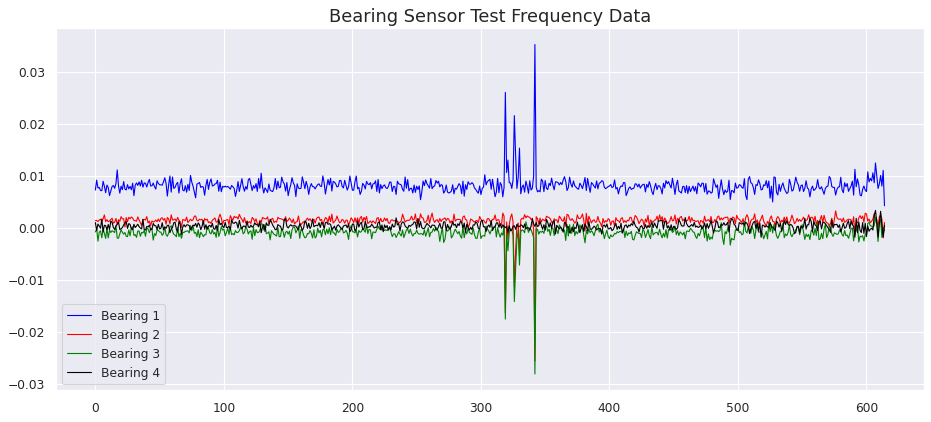

In [ ]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [ ]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [ ]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (367, 1, 4)
Test data shape: (615, 1, 4)


In [ ]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_9 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)              68    

In [ ]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
35/35 [==============================] - 5s 25ms/step - loss: 0.4004 - val_loss: 0.3251
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 0.3497 - val_loss: 0.2731
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 0.3017 - val_loss: 0.2199
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 0.2368 - val_loss: 0.1735
Epoch 5/100
35/35 [==============================] - 0s 4ms/step - loss: 0.1745 - val_loss: 0.1416
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 0.1177 - val_loss: 0.1182
Epoch 7/100
35/35 [==============================] - 0s 4ms/step - loss: 0.1096 - val_loss: 0.1165
Epoch 8/100
35/35 [==============================] - 0s 4ms/step - loss: 0.1067 - val_loss: 0.1118
Epoch 9/100
35/35 [==============================] - 0s 4ms/step - loss: 0.1012 - val_loss: 0.1099
Epoch 10/100
35/35 [==============================] - 0s 4ms/step - loss: 0.1049 - val_loss: 0.1092
Epoch 11

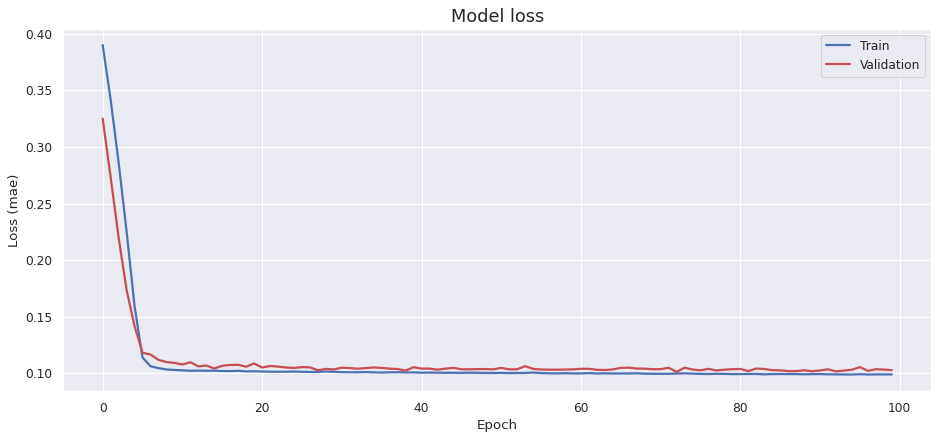

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

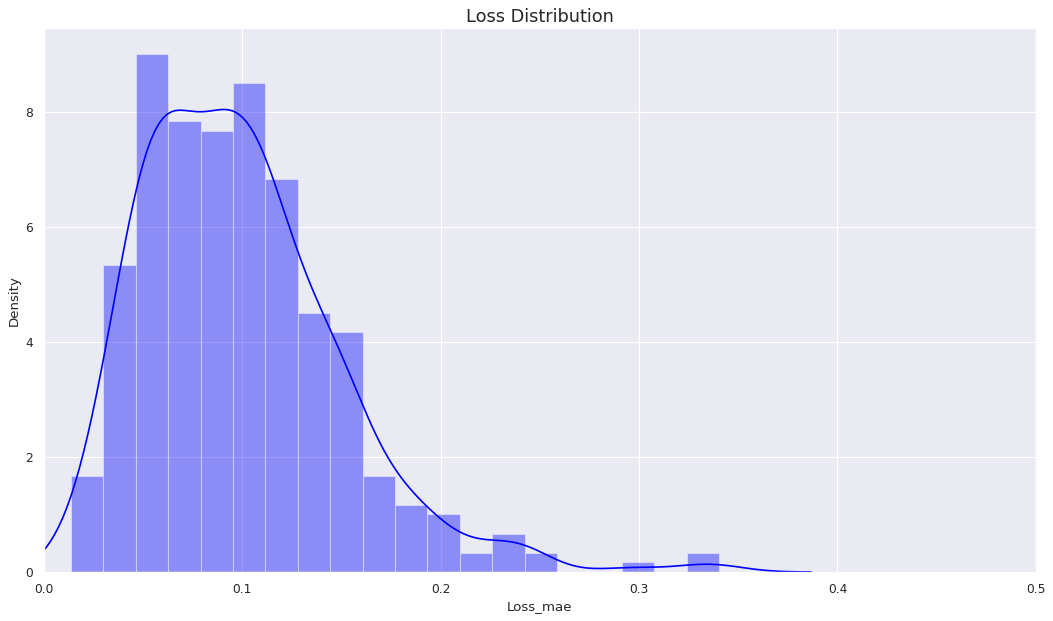

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004.02.15.00.02.39,0.092580,0.275,False
2004.02.15.00.12.39,0.082667,0.275,False
2004.02.15.00.22.39,0.126317,0.275,False
2004.02.15.00.32.39,0.019804,0.275,False
2004.02.15.00.42.39,0.066625,0.275,False


In [ ]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

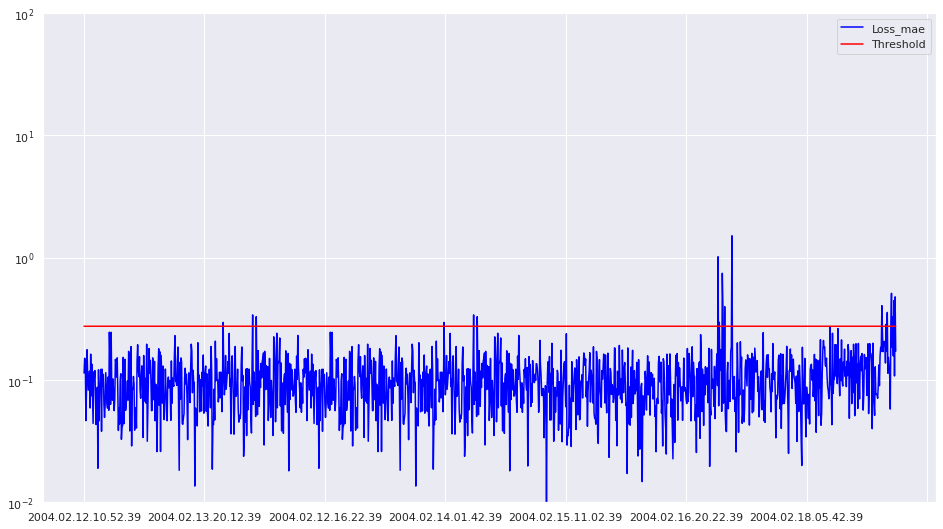

In [ ]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [ ]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved
